In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from pandas import DataFrame
from typing import cast
import matplotlib.pyplot as plt

from stochastic_volatility_models.src.core.underlying import Underlying
from stochastic_volatility_models.src.core.volatility_surface import VolatilitySurface
from stochastic_volatility_models.src.core.pricing_models import PricingModel
from stochastic_volatility_models.src.utils.options.strikes import find_closest_strikes
from stochastic_volatility_models.src.utils.options.expiry import time_to_expiry
from stochastic_volatility_models.src.data.rates import get_risk_free_interest_rate
from stochastic_volatility_models.src.data.dividends import get_dividend_yield
from stochastic_volatility_models.src.utils.options.strikes import moneyness

2024-07-30 21:15:32.386 | INFO     | stochastic_volatility_models.config:initialise:30 - Loaded module `stochastic_volatility_models` from project directory path `/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/Project/modules`


In [2]:
ticker = "VIX"
vix = Underlying(ticker)
pricing_model = PricingModel("Black-Scholes")
time = np.datetime64("2022-03-03")

In [3]:
expiries = np.array(["2022-03-09", "2022-03-23", "2022-03-30", "2022-04-06"], dtype=np.datetime64)

strikes = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
# strikes = np.array([4100, 4200,4250, 4260, 4270, 4280, 4290, 4300, 4310, 4320, 4340, 4350, 4360, 4370, 4380, 4400, 4500])
vix_vs = VolatilitySurface(
	underlying=vix,
	expiries=expiries,
	strikes=strikes,
	monthly=False,
)

In [4]:
volatility_surface = vix_vs
surface = volatility_surface.surface_quantities(
	time=time,
	quantity_method="empirical_pricing_implied_volatility",
	price_types=["Mid"],
	out_the_money=True,
	pricing_model=PricingModel(),
)[0]

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 94, 96, 104, 112, 120, 217, 225, 233, 241, 249, 257, 265, 267, 273, 275, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [50, 257, 265, 273, 281, 289, 297, 305]
  belo

T: 2022-03-09
r: 0.004351115078911429
q: 0.22423808535770673


/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 94, 96, 104, 112, 120, 217, 225, 233, 241, 249, 257, 265, 267, 273, 275, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311]

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [50, 257, 265, 273, 281, 289, 297, 305]



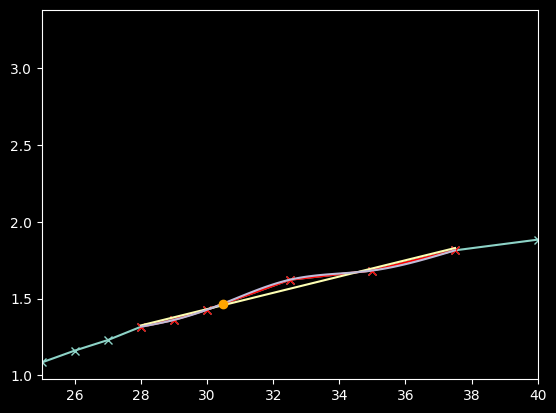

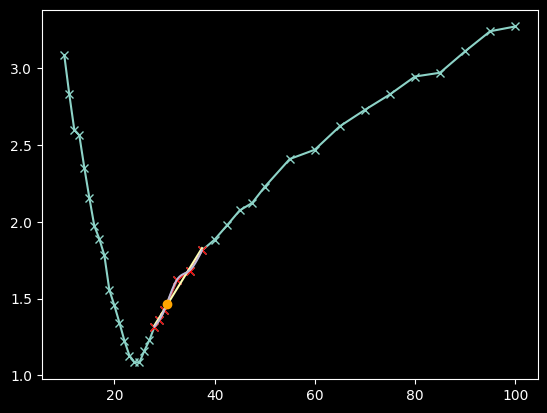

T: 2022-03-23
r: 0.0046537516427511165
q: 1.2178840017885353


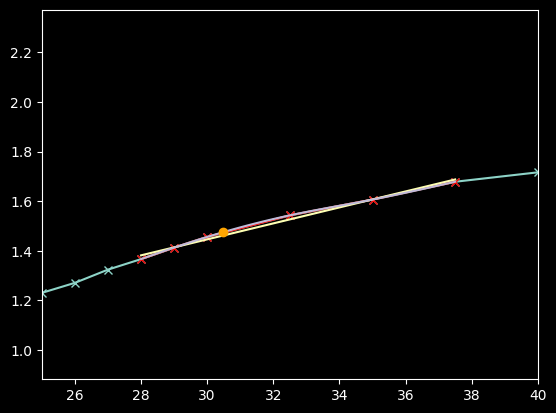

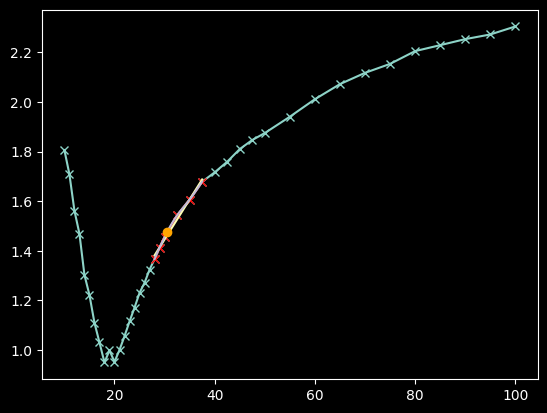

T: 2022-03-30
r: 0.004804684893290452
q: 0.8467822118706602


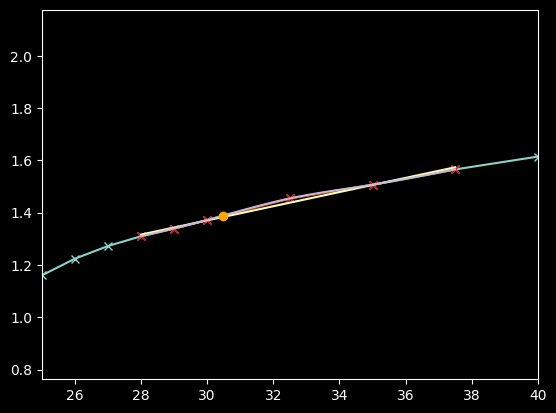

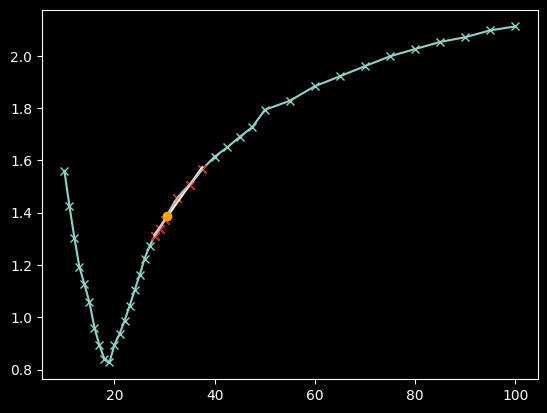

T: 2022-04-06
r: 0.0049550573047754095
q: 0.5672871116392249


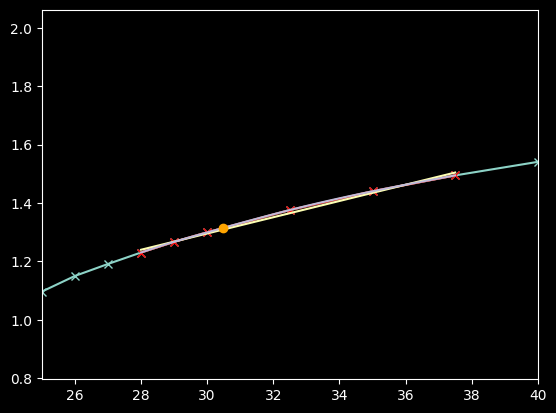

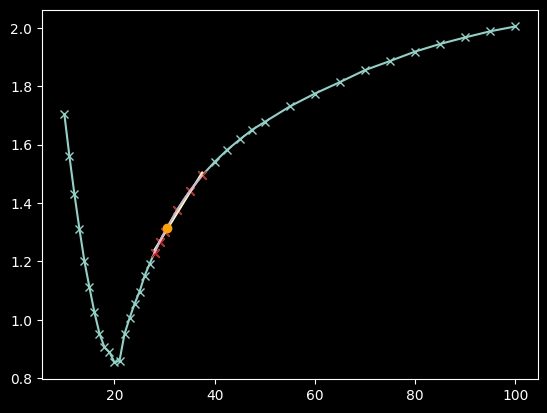

In [13]:
surface = volatility_surface.surface_quantities(
	time=time,
	quantity_method="empirical_pricing_implied_volatility",
	price_types=["Mid"],
	out_the_money=True,
	pricing_model=PricingModel("Black-Scholes-Merton"),
)[0]
for i, expiry in enumerate(volatility_surface.expiries):
	print(f"T: {expiry}")
	t2x = time_to_expiry(time, volatility_surface.expiries)
	print(f"r: {get_risk_free_interest_rate(time, t2x)[i]}")
	print(f"q: {get_dividend_yield(volatility_surface.underlying, time, volatility_surface.expiries, False)[i]}")
	indices = find_closest_strikes(
		strikes=volatility_surface.strikes,
		spot=volatility_surface.underlying.price(time=time),
	)
	# print(indices)
	cs = CubicSpline(
		x=indices,
		y=cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values,
		bc_type="natural",
	)
	x = np.linspace(indices.min(), indices.max(), 100)
	s, i = np.polyfit(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].to_numpy(), 1)

	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.plot(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values, linestyle=None, marker="x", color="red")
	plt.plot(x, s * x + i)
	plt.plot(x, cs(x))
	plt.plot((spot := volatility_surface.underlying.price(time=time)), cs(spot), color="orange", marker="o")
	plt.gca().set_xlim(25, 40)
	# plt.gca().set_ylim(1.2, 1.5)
	plt.show()

	plt.plot(volatility_surface.strikes, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[volatility_surface.strikes, "Symbol"].values, linestyle=None, marker="x")
	plt.plot(indices, cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].values, linestyle=None, marker="x", color="red")
	plt.plot(x, s * x + i)
	plt.plot(x, cs(x))
	plt.plot((spot := volatility_surface.underlying.price(time=time)), cs(spot), color="orange", marker="o")
	plt.show()

In [9]:
pricing_model = PricingModel()
volatility_surface = vix_vs

surfaces = [
	volatility_surface.surface_quantities(
		time=time,
		quantity_method="empirical_pricing_implied_volatility",
		price_types=["Mid"],
		out_the_money=True,
		pricing_model=pricing_model,
	)[0],
]

atm_skews = [
	DataFrame(
		[
			np.polyfit(
				x=moneyness(volatility_surface.underlying, indices, time, log=True),
				y=cast(DataFrame, surface.xs(key=expiry, level=1)).loc[indices, "Symbol"].to_numpy(),
				deg=1,
			)[0]
			for expiry in volatility_surface.expiries
			if (
				indices := find_closest_strikes(
					strikes=volatility_surface.strikes,
					spot=volatility_surface.underlying.price(time=time),
				)
			).any()
		],
		index=[expiry for expiry in volatility_surface.expiries],
		columns=["Skew"],
	)
	for surface in surfaces
]
print(indices)
print(vix_vs.underlying.price(time))
print(np.log(4363.49 / 4340))
print(moneyness(volatility_surface.underlying, indices, time, log=True))
atm_skews[0]

[28.  29.  30.  32.5 35.  37.5]
30.48
0.005397847768005915
[ 0.08486622  0.0497749   0.01587335 -0.06416936 -0.13827733 -0.2072702 ]


/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 94, 96, 104, 112, 120, 217, 225, 233, 241, 249, 257, 265, 267, 273, 275, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311]

/Users/mayurankv/Documents/Mayuran/Programming/Projects/Academic/Imperial College London/MSc Statistics/Dissertation/.venv/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning:

Found Below Intrinsic contracts at index [50, 257, 265, 273, 281, 289, 297, 305]



Skew
2022-03-09 -1.727303
2022-03-23 -1.049951
2022-03-30 -0.882016
2022-04-06 -0.906759